In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

df = pd.read_csv("dataset_diabetes/diabetes_data_preprocessed_original.csv")

df.shape
df.info()

df['readmitted'] = df['readmitted'].replace('>30', 2)
df['readmitted'] = df['readmitted'].replace('<30', 1)
df['readmitted'] = df['readmitted'].replace('NO', 0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91023 entries, 0 to 91022
Data columns (total 43 columns):
Unnamed: 0                  91023 non-null int64
encounter_id                91023 non-null int64
patient_nbr                 91023 non-null int64
race                        91023 non-null float64
gender                      91023 non-null int64
age                         91023 non-null float64
admission_type_id           91023 non-null int64
discharge_disposition_id    91023 non-null int64
admission_source_id         91023 non-null int64
time_in_hospital            91023 non-null float64
num_medications             91023 non-null float64
diag_1                      91023 non-null float64
diag_2                      91023 non-null float64
diag_3                      91023 non-null float64
number_diagnoses            91023 non-null float64
max_glu_serum               91023 non-null int64
A1Cresult                   91023 non-null int64
metformin                   91023 non-null

In [2]:
feature_set = ['encounter_id',                
'patient_nbr',                 
'race',                        
'gender',                      
'age',                         
'admission_type_id',           
'discharge_disposition_id',    
'admission_source_id',         
'time_in_hospital',            
'num_medications',             
'diag_1',                      
'diag_2',                      
'diag_3',                      
'number_diagnoses',            
'max_glu_serum',               
'A1Cresult',                   
'metformin',                   
'repaglinide',                 
'nateglinide',                 
'chlorpropamide',              
'glimepiride',                 
'acetohexamide',               
'glipizide',                   
'glyburide',                   
'tolbutamide',                 
'pioglitazone',                
'rosiglitazone',               
'acarbose',                    
'miglitol',                    
'troglitazone',                
'tolazamide',                  
'insulin',                     
'glyburide-metformin',         
'glipizide-metformin',         
'glimepiride-pioglitazone',    
'metformin-rosiglitazone',     
'metformin-pioglitazone',      
'change',                      
'diabetesMed',                 
'number_services',             
'num_total_procedures']

the_input = df[feature_set]
the_output = df['readmitted']

from imblearn.over_sampling import SMOTE
from collections import Counter

smt = SMOTE(random_state=20)
train_input_new, train_output_new = smt.fit_sample(the_input, the_output)
train_input_new = pd.DataFrame(train_input_new, columns = list(the_input.columns))

X_train, X_test, Y_train, Y_test = train_test_split(train_input_new, train_output_new, test_size=0.20, random_state=0)

In [4]:
print(X_train, X_test, Y_train, Y_test)
print(len(X_train), len(X_test), len(Y_train), len(Y_test))

        encounter_id   patient_nbr      race    gender       age  \
73051   2.513316e+08  9.052808e+07  0.174986  0.000000 -1.306313   
12069   5.363576e+07  4.182106e+07  0.174986  0.000000  1.201972   
2374    1.722436e+07  1.130331e+08  0.174986  0.000000  0.574901   
59432   1.844201e+08  8.997041e+07  0.174986  1.000000  1.201972   
137638  7.735902e+07  4.865508e+06 -0.063156  1.000000 -0.770271   
120547  5.995989e+07  6.550024e+05 -0.158706  0.000000 -0.796098   
130754  1.008520e+08  5.983323e+07  0.174986  0.657987 -0.068498   
17144   6.846376e+07  3.802266e+06  0.174986  0.000000 -0.679242   
9687    4.556339e+07  2.445660e+05  0.174986  0.000000 -0.679242   
141814  2.698650e+08  8.558346e+07  0.174986  1.000000  0.713150   
90579   4.366869e+08  1.365454e+08  0.174986  1.000000 -0.679242   
112511  7.919471e+07  2.812667e+07  0.174986  0.787770 -0.279991   
82955   3.219662e+08  6.823030e+07  0.174986  0.000000 -0.052170   
29786   1.057375e+08  2.347804e+07  0.174986  1.

In [8]:
# XGBOOST

# xg_reg = xgb.XGBClassifier(colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=250,
#                           objective='multi:softprob', subsample=1)
xg_reg = xgb.XGBClassifier()

print("Cross Validation score: ", np.mean(cross_val_score(xg_reg, X_train, Y_train, cv=10)))
xg_reg.fit(X_train,Y_train)

Y_test_predict = xg_reg.predict(X_test)
print("Accuracy: ",accuracy_score(Y_test, Y_test_predict))

Cross Validation score:  0.6207587038694424
Accuracy:  0.6242231735948074


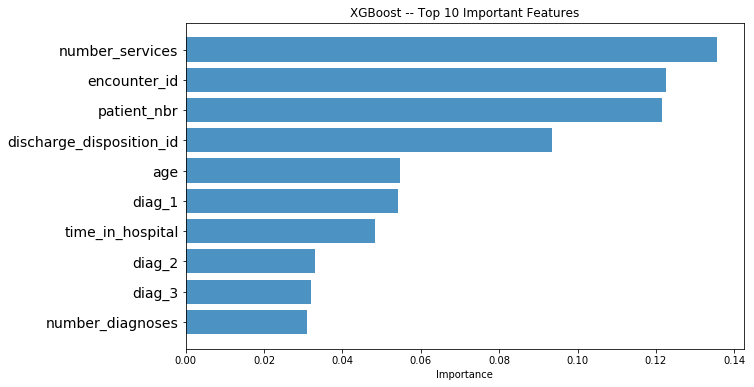

In [6]:
# XGBOOST TOP FEATURES DIAGRAM

feature_names = X_train.columns
feature_imports = xg_reg.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('XGBoost -- Top 10 Important Features')
plt.show()

In [9]:
# RANDOM FOREST

forest = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = "entropy", min_samples_split=10)

print("Cross Validation Score: ", np.mean(cross_val_score(forest, X_train, Y_train, cv=10)))
forest.fit(X_train, Y_train)

Y_test_predict = forest.predict(X_test)
print("Accuracy: ", accuracy_score(Y_test, Y_test_predict))

Cross Validation Score: 
Accuracy:  0.6241541223587902


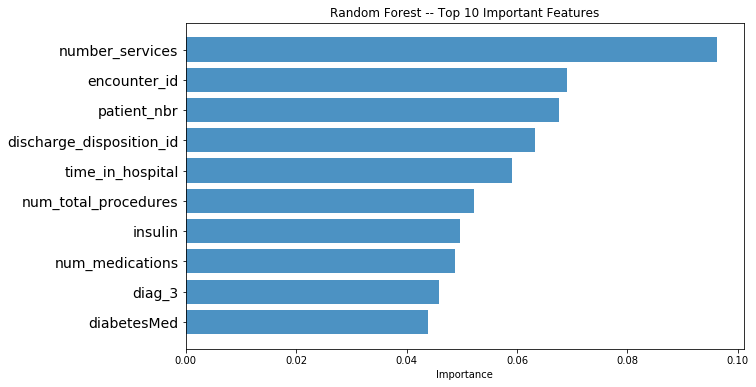

In [10]:
# RANDOM FOREST TOP FEATURES DIAGRAM

feature_names = X_train.columns
feature_imports = forest.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Random Forest -- Top 10 Important Features')
plt.show()